To use:
- Mount Drive
- Upload models.py
- Select file by commenting

In [ ]:
# Run this cell if using Google Colab
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/JP_gmvae_data/

Mounted at /content/drive


./VAE_figs/1_uniform_new_cn_dim7_48x32x24_beta0.0014_batch128_epochs2000_0601094110
Loaded 1639 samples with label 0.
total loss function calls:  25609.375
VAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=48, bias=True)
      (1): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=48, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
    (2): Sequential(
      (0): Linear(in_features=32, out_features=24, bias=True)
      (1): GELU(approximate='none')
    )
  )
  (fc_mu): Linear(in_features=24, out_features=7, bias=True)
  (fc_var): Linear(in_features=24, out_features=7, bias=True)
  (decoder_input): Linear(in_features=7, out_features=24, bias=True)
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=24, out_features=32, bias=True)
      (1): GELU(approximate='none')
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=48, bias=True)
      (1):

100%|██████████| 2000/2000 [00:44<00:00, 44.89 Epoch/s, loss=0.0145]


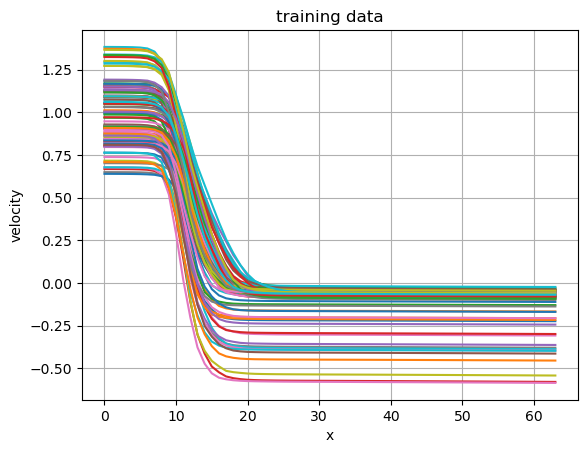

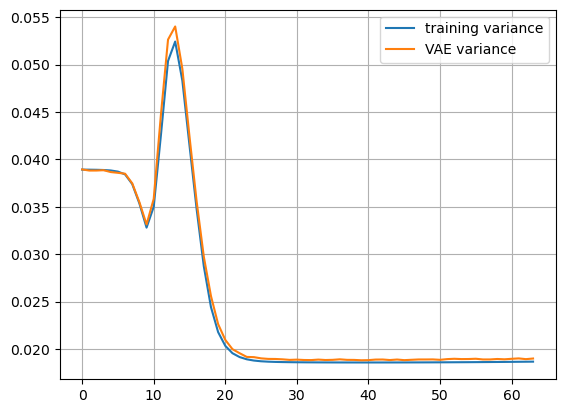

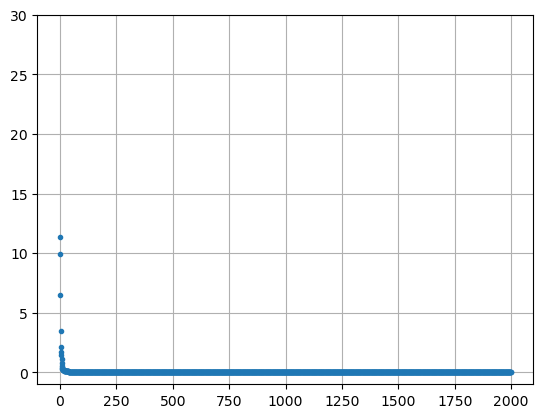

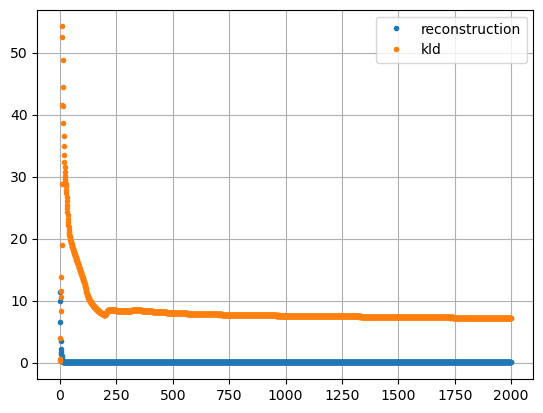

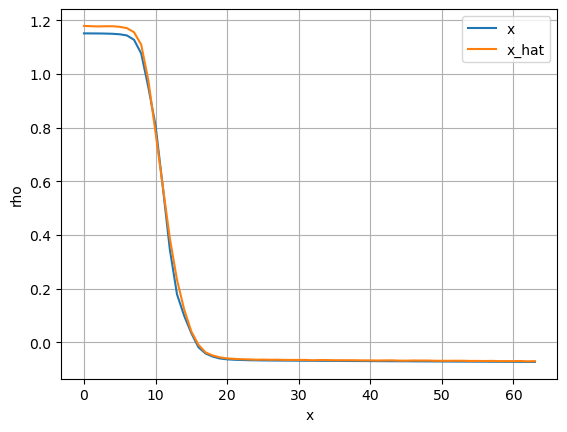

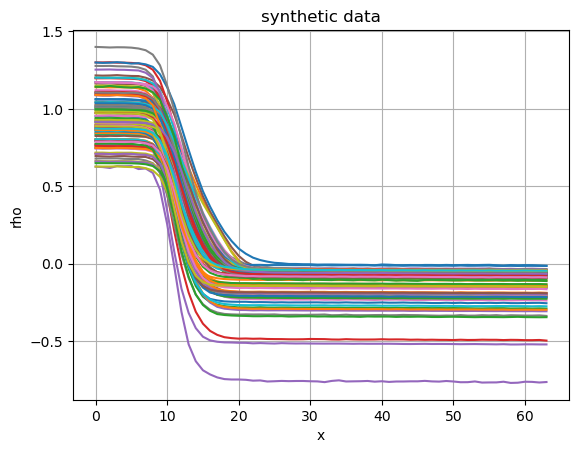

In [5]:
import torch 
from models import VAE # import the VAE model
import numpy as np
import matplotlib.pyplot as plt
import pandas
import json
from scipy.io import savemat
from scipy import stats
import scipy
import datetime
import os
import random

# Make determinsitic
SEED = 42  # or any fixed number

# Python, NumPy, PyTorch seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# For deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Optional: ensure reproducibility across runs
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # Needed for CUDA <11.2

plt.close('all')

#%% SETTINGS
DataType = 'cn'
# Set 1
# LatentDim = 8
# HiddenDims = [64, 32, 16] # define the strucute of the encoder and decoder
# Beta = .0013
# Set 2
LatentDim = 7
HiddenDims = [48, 32, 24] # define the strucute of the encoder and decoder
Beta = .0014

BatchSize = 128
Epochs = 2000
IsTest = False # when True, don't save figures or create directory
tag = '1_uniform_new' # UOP_near_crash_steeper  UOP_near_crash  UOP_inc_lit_disps 1_near_crash 1_near_escape

# load training data
# json_file = f'/Users/gracecalkins/Local_Documents/local_code/pipag_training/data/1_near_crash_new_2000_data_energy_scaled_downsampled_.json'
# json_file = f'/Users/gracecalkins/Local_Documents/local_code/pipag_training/data/1_near_escape_new_2000_data_energy_scaled_downsampled_.json'
# json_file = f'/Users/gracecalkins/Local_Documents/local_code/pipag_training/data/1_near_escape_fnpag_2000_data_energy_scaled_downsampled_.json'
json_file = f'/Users/gracecalkins/Local_Documents/local_code/pipag_training/data/1_uniform_new_2000_data_energy_scaled_downsampled_.json'

date = datetime.datetime.now().strftime('%m%d%H%M%S')


# Create parent 'figs' folder if it doesn't exist
if not os.path.exists('./VAE_figs'):
   os.mkdir('./VAE_figs')

dirname = './VAE_figs/' + tag + '_' + DataType\
       + '_dim' + str(LatentDim) + '_'
for i, d in enumerate(HiddenDims):
   dirname += str(HiddenDims[i])
   if i < len(HiddenDims) - 1:
       dirname += 'x'
dirname += '_beta' + str(Beta)\
       + '_batch' + str(BatchSize)\
       + '_epochs' + str(Epochs)\
       + '_' + date

# Then create the specific subfolder
if not IsTest:
   os.mkdir(dirname)
print(dirname)

# set device
Dev = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Load the JSON file
with open(json_file, 'r') as f:
    dataset = json.load(f)

# dataset is a dict: sample0, sample1, etc.
# Collect energy arrays where label == 0 (capture scenarios)
filtered_data = [entry['energy'] for entry in dataset.values() if entry['label'] == 0]

for i in range(len(filtered_data)):
   if np.isnan(filtered_data[i]).any():
      print("nan values")

# Convert to numpy array
data = np.array(filtered_data)

n_data, k_data = data.shape # define number of samples and features

x_trn = torch.from_numpy(data).type(torch.FloatTensor).to(Dev)
x_trn_cpu = x_trn.cpu()

print('Loaded {} samples with label 0.'.format(len(filtered_data)))
print('total loss function calls: ', len(data)/BatchSize*Epochs)


# draw the training data
fig, ax = plt.subplots()
ax.grid()
ax.set_title('training data')
ax.set_xlabel('x')
ax.set_ylabel('velocity')

for i in range(min(100, len(filtered_data))):
    ax.plot(x_trn_cpu[i])

#if not IsTest:
#    plt.savefig(dirname + '/trainingData.png')


#%% train
vae_model = VAE(k_data,
                latent_dim = LatentDim, # define the latent dimension of the auto-encoder
                hidden_dims = HiddenDims, # define the strucute of the encoder and decoder
                beta = Beta,
                dev = Dev
               )
vae_model.to(Dev)
print(vae_model)
epoch_loss, rec_loss, kld_loss = vae_model.train(x_trn,
                                                 batch_size = BatchSize,
                                                 epochs = Epochs
                                                 ) # train the vae model using synthetic data


#%% plots
# compare variance
tind = 10
x = x_trn_cpu[tind]
x_hat = vae_model.generate(x_trn[tind]).cpu()
big_samp = vae_model.sample(num_samples = n_data).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.plot(stats.describe(x_trn_cpu, axis = 0)[3], label = 'training variance')
ax.plot(stats.describe(big_samp.detach(), axis = 0)[3], label = 'VAE variance')
ax.legend()

# Save off big_samp
if not IsTest:
   savemat(dirname + '/big_samp.mat', {'big_samp': big_samp.detach().numpy()})
   # Save off x_trn_cpu
   savemat(dirname + '/x_trn_cpu.mat', {'x_trn_cpu': x_trn_cpu.numpy()})

if not IsTest:
   plt.savefig(dirname + '/variance.png')

# total loss
fig, ax = plt.subplots()
ax.grid()
ax.plot(epoch_loss, '.')
ax.set_ylim(-1, 30)

if not IsTest:
   plt.savefig(dirname + '/loss.png')

# loss sources
fig, ax = plt.subplots()
ax.grid()
ax.plot(rec_loss, '.', label = 'reconstruction')
ax.plot(kld_loss, '.', label = 'kld')
ax.legend()

if not IsTest:
   plt.savefig(dirname + '/losses.png')

# reconstruction error
fig, ax = plt.subplots()
ax.grid()

ax.plot(x, label = 'x')
ax.plot(x_hat.detach(), label = 'x_hat')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('rho')

if not IsTest:
   plt.savefig(dirname + '/reconstruction.png')

# synthetic data
new_samp = vae_model.sample(num_samples = 100).cpu()
fig, ax = plt.subplots()
ax.grid()
ax.set_title('synthetic data')
#ax.set_xlim(-1.1, 2.2)
ax.set_xlabel('x')
ax.set_ylabel('rho')

for i in range(100):
    ax.plot(new_samp[i].detach())
if not IsTest:
   plt.savefig(dirname + '/syntheticData.png')
